https://www.reddit.com/r/nba/comments/4p63ku/ysk_simpsons_paradox_and_basketball/

https://www.reddit.com/r/nba/comments/nnpzg3/simpsons_paradox_curry_shot_a_higher_2p_and_3p/

https://en.wikipedia.org/wiki/Simpson%27s_paradox#Examples

https://www.nba.com/stats/vs/#!/?PlayerID=201939&VsPlayerID=201566

https://www.nba.com/stats/player/201939/shooting/

In [1]:
# %pip install nba_api
# %pip install altair altair_saver

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')
import numpy as np
import pandas as pd
import tqdm
import glob
import os
import pickle

from nba_api.stats.static import teams, players
from nba_api.stats.endpoints import commonplayoffseries, playoffpicture, boxscoresummaryv2, leaguegamefinder,\
playbyplayv2, commonplayerinfo, commonallplayers
from nba_api.stats.library.parameters import Season, SeasonType, LeagueIDNullable, PerModeSimpleNullable,\
SeasonTypePlayoffs, SeasonSegmentNullable
from nba_api.stats.library.eventmsgtype import EventMsgType

from nba_api.stats.endpoints import BoxScoreMatchups, LeagueSeasonMatchups, PlayerDashPtShotDefend, PlayerDashboardByShootingSplits

import altair as alt
from altair_saver import save as alt_save

pd.options.display.max_columns = 30
pd.options.display.max_rows = 100

/home/noone/.virtualenvs/env37/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


#  data

In [3]:
df = (
    pd.read_pickle('../active_players_seasons_stats_19012022.pickle.zip')
    .query("(SEASON_ID == '2021-22') and (FGA > 500)")
)
df['FG2A'] = df.FGA - df.FG3A
df['FG2M'] = df.FGM - df.FG3M
df['FG2_PCT'] = df.FG2M / df.FG2A.where(df.FG2A > 0, 1) 
print(df.shape)
df.head(2)

(55, 30)


,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,FG2A,FG2M,FG2_PCT
2,1629638,2021-22,00,1610612740,NOP,23.0,41,18,1089.0,198,534,0.371,82,262,0.313,48,69,0.696,32,106,138,104,35,13,66,72,526,272,116,0.426471
8,203507,2021-22,00,1610612749,MIL,27.0,37,37,1208.0,364,681,0.535,40,142,0.282,285,400,0.713,67,346,413,225,37,55,128,119,1053,539,324,0.601113


In [4]:
p = pd.read_pickle('../player_profiles/1629638.pickle')
dir(p)
p.common_player_info.get_data_frame()
# p.get_data_frames()[1] #player_stats)

,PERSON_ID,FIRST_NAME,LAST_NAME,DISPLAY_FIRST_LAST,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FI_LAST,PLAYER_SLUG,BIRTHDATE,SCHOOL,COUNTRY,LAST_AFFILIATION,HEIGHT,WEIGHT,SEASON_EXP,JERSEY,...,GAMES_PLAYED_CURRENT_SEASON_FLAG,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CODE,TEAM_CITY,PLAYERCODE,FROM_YEAR,TO_YEAR,DLEAGUE_FLAG,NBA_FLAG,GAMES_PLAYED_FLAG,DRAFT_YEAR,DRAFT_ROUND,DRAFT_NUMBER
0,1629638,Nickeil,Alexander-Walker,Nickeil Alexander-Walker,"Alexander-Walker, Nickeil",N. Alexander-Walker,nickeil-alexander-walker,1998-09-02T00:00:00,Virginia Tech,Canada,Virginia Tech/Canada,6-5,205,1,0,...,Y,1610612740,Pelicans,NOP,pelicans,New Orleans,nickeil_alexander-walker,2019,2020,Y,Y,Y,2019,1,17


In [5]:
player_dict = {}
for p_id in df.PLAYER_ID.unique():
    p = pd.read_pickle(f'../player_profiles/{p_id}.pickle')
    slug = p.common_player_info.get_data_frame().DISPLAY_FIRST_LAST.iloc[0]
    player_dict[p_id] = slug
df['player_slug'] = df.PLAYER_ID.map(player_dict)
df.set_index(df.player_slug, inplace=True)
df.head(2)

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,...,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,FG2A,FG2M,FG2_PCT,player_slug
player_slug,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Nickeil Alexander-Walker,1629638,2021-22,00,1610612740,NOP,23.0,41,18,1089.0,198,534,0.371,82,262,0.313,...,69,0.696,32,106,138,104,35,13,66,72,526,272,116,0.426471,Nickeil Alexander-Walker
Giannis Antetokounmpo,203507,2021-22,00,1610612749,MIL,27.0,37,37,1208.0,364,681,0.535,40,142,0.282,...,400,0.713,67,346,413,225,37,55,128,119,1053,539,324,0.601113,Giannis Antetokounmpo


In [6]:
df[df.FG3A < 10]

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,...,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,FG2A,FG2M,FG2_PCT,player_slug
player_slug,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [7]:
shooting_splits_dir = '../shooting_splits_2021/'
def load_splits(player_id):
    fname = os.path.join(shooting_splits_dir, f'{player_id}.pkl')
    with open(fname, 'rb') as f:
        dfs = pickle.load(f)
    return dfs
dfs = load_splits(1629638)
dfs[1].GROUP_VALUE.to_list()

['Less Than 5 ft.',
 '5-9 ft.',
 '10-14 ft.',
 '15-19 ft.',
 '20-24 ft.',
 '25-29 ft.',
 '30-34 ft.',
 '35-39 ft.',
 '40+ ft.']

# splits

In [8]:
def get_split(df, split_dict):
    res = []
    keys = []
    for k, l in split_dict.items():
        fgm = df.FGM[df.GROUP_VALUE.isin(l)].sum()
        fga = df.FGA[df.GROUP_VALUE.isin(l)].sum()
        if fga > 0:
            res.append((fga, fgm, fgm / fga))
        else:
            res.append((fga, fgm, 0))
        keys.append(k)
    return (
        pd.DataFrame(res, index=keys, columns=['FGA', 'FGM', '%'])
        .stack(dropna=False).to_frame().T
    )

SHOT_AREA_3SPLIT = {'paint': ['Restricted Area', 'In The Paint (Non-RA)'],
                    'mid': ['Mid-Range'],
                    '3pt': ['Left Corner 3', 'Right Corner 3', 
                            'Above the Break 3', 'Backcourt']}
SHOT_AREA_ALL_SPLIT = {'Из-под кольца': ['Restricted Area'], 
                       'Из краски': ['In The Paint (Non-RA)'],
                    'Со средней': ['Mid-Range'],
                    '3 слева': ['Left Corner 3'], '3 справа': ['Right Corner 3'],
                    '3 по центру': ['Above the Break 3'], 'Со своей половины': ['Backcourt']}
AREAS_ZONES = list(SHOT_AREA_ALL_SPLIT.keys())
print(AREAS_ZONES)
dd = get_split(dfs[3], SHOT_AREA_3SPLIT)
dd

['Из-под кольца', 'Из краски', 'Со средней', '3 слева', '3 справа', '3 по центру', 'Со своей половины']


paint                   mid                    3pt                
     FGA    FGM        %   FGA   FGM         %    FGA   FGM         %
0  235.0  111.0  0.47234  64.0  17.0  0.265625  274.0  86.0  0.313869

In [9]:
AREAS_8FT = ['Less Than 8 ft.', '8-16 ft.', '16-24 ft.', '24+ ft.']
SHOT_DIST_8FT = {v: [v] for v in AREAS_8FT}
get_split(dfs[2], SHOT_DIST_8FT)

Less Than 8 ft.                 8-16 ft.                16-24 ft.       \
              FGA   FGM         %      FGA   FGM        %       FGA  FGM   
0           202.0  98.0  0.485149     62.0  21.0  0.33871      35.0  9.0   

            24+ ft.                  
          %     FGA   FGM         %  
0  0.257143   272.0  86.0  0.316176

In [10]:
AREAS_5FT = ['Less Than 5 ft.', '5-9 ft.', '10-14 ft.', '15-19 ft.', '20-24 ft.', 
             '25-29 ft.', '30-34 ft.', '35-39 ft.', '40+ ft.']
SHOT_DIST_5FT = {v: [v] for v in AREAS_5FT}
get_split(dfs[1], SHOT_DIST_5FT)

Less Than 5 ft.                 5-9 ft.              10-14 ft.        \
              FGA   FGM         %     FGA   FGM      %       FGA   FGM   
0           178.0  91.0  0.511236    40.0  13.0  0.325      39.0  14.0   

            15-19 ft.                20-24 ft.                 25-29 ft.  \
          %       FGA  FGM         %       FGA   FGM         %       FGA   
0  0.358974      34.0  8.0  0.235294     122.0  40.0  0.327869     158.0   

                  30-34 ft.           35-39 ft.           40+ ft.            
    FGM         %       FGA  FGM    %       FGA  FGM    %     FGA  FGM    %  
0  48.0  0.303797       0.0  0.0  0.0       0.0  0.0  0.0     2.0  0.0  0.0

In [11]:
def combine(df, split_num, split_dict):
    splits = df.PLAYER_ID.apply(lambda pl: get_split(load_splits(pl)[split_num], split_dict)).values
    result = pd.concat(splits)
    return result.set_index(df.index)

df_split_sa3 = combine(df, 3, SHOT_AREA_3SPLIT)
print(df_split_sa3.shape)
df_split_sa3.head(2)

(55, 9)


paint                     mid                  \
                            FGA    FGM         %    FGA   FGM         %   
player_slug                                                               
Nickeil Alexander-Walker  235.0  111.0  0.472340   64.0  17.0  0.265625   
Giannis Antetokounmpo     469.0  308.0  0.656716  121.0  43.0  0.355372   

                            3pt                  
                            FGA   FGM         %  
player_slug                                      
Nickeil Alexander-Walker  274.0  86.0  0.313869  
Giannis Antetokounmpo     152.0  43.0  0.282895

In [12]:
df_split_sa = combine(df, 3, SHOT_AREA_ALL_SPLIT)
print(df_split_sa.shape)
df_split_sa.head(2)

(55, 21)


Из-под кольца                  Из краски        \
                                   FGA    FGM         %       FGA   FGM   
player_slug                                                               
Nickeil Alexander-Walker         159.0   85.0  0.534591      76.0  26.0   
Giannis Antetokounmpo            340.0  259.0  0.761765     129.0  49.0   

                                   Со средней                 3 слева        \
                                 %        FGA   FGM         %     FGA   FGM   
player_slug                                                                   
Nickeil Alexander-Walker  0.342105       64.0  17.0  0.265625    40.0  13.0   
Giannis Antetokounmpo     0.379845      121.0  43.0  0.355372     1.0   0.0   

                                3 справа                 3 по центру        \
                              %      FGA   FGM         %         FGA   FGM   
player_slug                                                                  
Nickeil Alexander-Walker  0.325     28.0  11.0  0.392857       205.0  62.0   
Giannis Antetokounmpo     0.000      0.0   0.0  0.000000       150.0  43.0   

                                   Со своей половины            
                                 %               FGA  FGM    %  
player_slug                                                     
Nickeil Alexander-Walker  0.302439               1.0  0.0  0.0  
Giannis Antetokounmpo     0.286667               1.0  0.0  0.0

In [13]:
df_split_8ft = combine(df, 2, SHOT_DIST_8FT)
print(df_split_8ft.shape)
df_split_8ft.head(2)

(55, 12)


Less Than 8 ft.                  8-16 ft.        \
                                     FGA    FGM         %      FGA   FGM   
player_slug                                                                
Nickeil Alexander-Walker           202.0   98.0  0.485149     62.0  21.0   
Giannis Antetokounmpo              414.0  282.0  0.681159    118.0  48.0   

                                  16-24 ft.                 24+ ft.        \
                                %       FGA   FGM         %     FGA   FGM   
player_slug                                                                 
Nickeil Alexander-Walker  0.33871      35.0   9.0  0.257143   272.0  86.0   
Giannis Antetokounmpo     0.40678      58.0  21.0  0.362069   151.0  43.0   

                                    
                                 %  
player_slug                         
Nickeil Alexander-Walker  0.316176  
Giannis Antetokounmpo     0.284768

In [14]:
df_split_5ft = combine(df, 1, SHOT_DIST_5FT)
print(df_split_5ft.shape)
df_split_5ft.head(2)

(55, 27)


Less Than 5 ft.                  5-9 ft.        \
                                     FGA    FGM         %     FGA   FGM   
player_slug                                                               
Nickeil Alexander-Walker           178.0   91.0  0.511236    40.0  13.0   
Giannis Antetokounmpo              366.0  272.0  0.743169    71.0  19.0   

                                   10-14 ft.                 15-19 ft.        \
                                 %       FGA   FGM         %       FGA   FGM   
player_slug                                                                    
Nickeil Alexander-Walker  0.325000      39.0  14.0  0.358974      34.0   8.0   
Giannis Antetokounmpo     0.267606      82.0  35.0  0.426829      61.0  24.0   

                                   20-24 ft.                 25-29 ft.        \
                                 %       FGA   FGM         %       FGA   FGM   
player_slug                                                                    
Nickeil Alexander-Walker  0.235294     122.0  40.0  0.327869     158.0  48.0   
Giannis Antetokounmpo     0.393443      21.0   4.0  0.190476     137.0  40.0   

                                   30-34 ft.           35-39 ft.            \
                                 %       FGA  FGM    %       FGA  FGM    %   
player_slug                                                                  
Nickeil Alexander-Walker  0.303797       0.0  0.0  0.0       0.0  0.0  0.0   
Giannis Antetokounmpo     0.291971       2.0  0.0  0.0       1.0  0.0  0.0   

                         40+ ft.            
                             FGA  FGM    %  
player_slug                                 
Nickeil Alexander-Walker     2.0  0.0  0.0  
Giannis Antetokounmpo        1.0  0.0  0.0

In [15]:
PT_SPLIT = {'2PT': ['Restricted Area', 'In The Paint (Non-RA)', 'Mid-Range'],
            '3PT': ['Left Corner 3', 'Right Corner 3', 
                    'Above the Break 3', 'Backcourt']}
df_split_pt = combine(df, 3, PT_SPLIT)
print(df_split_pt.shape)
df_split_pt.head(2)

(55, 6)


2PT                     3PT                
                            FGA    FGM         %    FGA   FGM         %
player_slug                                                            
Nickeil Alexander-Walker  299.0  128.0  0.428094  274.0  86.0  0.313869
Giannis Antetokounmpo     590.0  351.0  0.594915  152.0  43.0  0.282895

In [16]:
TOTAL_SPLIT = {'Total': ['Restricted Area', 'In The Paint (Non-RA)', 'Mid-Range', 
                         'Left Corner 3', 'Right Corner 3', 
                         'Above the Break 3', 'Backcourt']}

df_split_total = combine(df, 3, TOTAL_SPLIT)
print(df_split_total.shape)
df_split_total.head(2)

(55, 3)


Total                 
                            FGA    FGM         %
player_slug                                     
Nickeil Alexander-Walker  573.0  214.0  0.373473
Giannis Antetokounmpo     742.0  394.0  0.530997

In [17]:
df_all = pd.concat([df_split_total, df_split_pt, df_split_sa3, df_split_sa, df_split_8ft, df_split_5ft], axis=1)
print(df_all.shape)
df_all[('num', 'num')] = 0
df_all.head(2)

(55, 78)


Total                     2PT                   \
                            FGA    FGM         %    FGA    FGM         %   
player_slug                                                                
Nickeil Alexander-Walker  573.0  214.0  0.373473  299.0  128.0  0.428094   
Giannis Antetokounmpo     742.0  394.0  0.530997  590.0  351.0  0.594915   

                            3PT                  paint                   \
                            FGA   FGM         %    FGA    FGM         %   
player_slug                                                               
Nickeil Alexander-Walker  274.0  86.0  0.313869  235.0  111.0  0.472340   
Giannis Antetokounmpo     152.0  43.0  0.282895  469.0  308.0  0.656716   

                            mid                  ... 20-24 ft.            \
                            FGA   FGM         %  ...       FGM         %   
player_slug                                      ...                       
Nickeil Alexander-Walker   64.0  17.0  0.265625  ...      40.0  0.327869   
Giannis Antetokounmpo     121.0  43.0  0.355372  ...       4.0  0.190476   

                         25-29 ft.                 30-34 ft.            \
                               FGA   FGM         %       FGA  FGM    %   
player_slug                                                              
Nickeil Alexander-Walker     158.0  48.0  0.303797       0.0  0.0  0.0   
Giannis Antetokounmpo        137.0  40.0  0.291971       2.0  0.0  0.0   

                         35-39 ft.           40+ ft.           num  
                               FGA  FGM    %     FGA  FGM    % num  
player_slug                                                         
Nickeil Alexander-Walker       0.0  0.0  0.0     2.0  0.0  0.0   0  
Giannis Antetokounmpo          1.0  0.0  0.0     1.0  0.0  0.0   0  

[2 rows x 79 columns]

# simpson

In [18]:
def find_simpson(df, total_pct_col, splits_pct_cols):
    sp = []
    cols = splits_pct_cols + [total_pct_col, 'num']
    pct_cols = splits_pct_cols + [total_pct_col]
    num = 0
    for i in range(len(df)):
        r = df.iloc[i]
        idx = df[(total_pct_col, '%')] > r[(total_pct_col, '%')]
        for c in splits_pct_cols:
            idx = idx & (df[(c, '%')] <= r[(c, '%')])
        s = df[idx]
        for j in range(len(s)):
            pair_r = s.iloc[j]
            num += 1
            rc = df.iloc[i: i+1][cols].copy()
            pair_rc = s.iloc[j: j+1][cols].copy()
            pair_df = pd.concat([rc, pair_rc], axis=0)
            pair_df[('num', 'num')] = num
            sp.append(pair_df)
    sp = pd.concat(sp)
    return (
        sp
        .set_index([('num', 'num')], append=True)
        .rename_axis(index={('num', 'num'): 'num'})
        .swaplevel()
    )


sp_2_3 = find_simpson(df_all, total_pct_col='Total', splits_pct_cols=['2PT', '3PT'])
print(sp_2_3.shape)
sp_2_3.head(2)

(168, 9)


2PT                     3PT                   \
                                FGA    FGM         %    FGA    FGM         %   
num player_slug                                                                
1   Malik Beasley             155.0   67.0  0.432258  398.0  137.0  0.344221   
    Nickeil Alexander-Walker  299.0  128.0  0.428094  274.0   86.0  0.313869   

                              Total                   
                                FGA    FGM         %  
num player_slug                                       
1   Malik Beasley             553.0  204.0  0.368897  
    Nickeil Alexander-Walker  573.0  214.0  0.373473

In [19]:
sp_2_3.loc[sp_2_3[sp_2_3.index.get_level_values('player_slug').str.contains('Westb')].index.get_level_values('num')]

2PT                     3PT                   Total  \
                         FGA    FGM         %    FGA    FGM         %    FGA   
num player_slug                                                                
16  Jordan Clarkson    295.0  147.0  0.498305  382.0  125.0  0.327225  677.0   
    Russell Westbrook  620.0  297.0  0.479032  167.0   50.0  0.299401  787.0   
22  Stephen Curry      333.0  162.0  0.486486  569.0  215.0  0.377856  902.0   
    Russell Westbrook  620.0  297.0  0.479032  167.0   50.0  0.299401  787.0   
24  Luka Doncic        434.0  225.0  0.518433  267.0   80.0  0.299625  701.0   
    Russell Westbrook  620.0  297.0  0.479032  167.0   50.0  0.299401  787.0   
29  Paul George        339.0  164.0  0.483776  217.0   70.0  0.322581  556.0   
    Russell Westbrook  620.0  297.0  0.479032  167.0   50.0  0.299401  787.0   
31  James Harden       382.0  185.0  0.484293  294.0   99.0  0.336735  676.0   
    Russell Westbrook  620.0  297.0  0.479032  167.0   50.0  0.299401  787.0   
33  Jaren Jackson Jr.  401.0  193.0  0.481297  267.0   84.0  0.314607  668.0   
    Russell Westbrook  620.0  297.0  0.479032  167.0   50.0  0.299401  787.0   
43  Damian Lillard     268.0  130.0  0.485075  284.0   92.0  0.323944  552.0   
    Russell Westbrook  620.0  297.0  0.479032  167.0   50.0  0.299401  787.0   
66  Jordan Poole       253.0  142.0  0.561265  306.0  104.0  0.339869  559.0   
    Russell Westbrook  620.0  297.0  0.479032  167.0   50.0  0.299401  787.0   
70  Terry Rozier       303.0  150.0  0.495050  315.0  118.0  0.374603  618.0   
    Russell Westbrook  620.0  297.0  0.479032  167.0   50.0  0.299401  787.0   
73  Jayson Tatum       574.0  281.0  0.489547  377.0  125.0  0.331565  951.0   
    Russell Westbrook  620.0  297.0  0.479032  167.0   50.0  0.299401  787.0   
77  Nikola Vucevic     427.0  209.0  0.489461  201.0   67.0  0.333333  628.0   
    Russell Westbrook  620.0  297.0  0.479032  167.0   50.0  0.299401  787.0   

                                        
                         FGM         %  
num player_slug                         
16  Jordan Clarkson    272.0  0.401773  
    Russell Westbrook  347.0  0.440915  
22  Stephen Curry      377.0  0.417960  
    Russell Westbrook  347.0  0.440915  
24  Luka Doncic        305.0  0.435093  
    Russell Westbrook  347.0  0.440915  
29  Paul George        234.0  0.420863  
    Russell Westbrook  347.0  0.440915  
31  James Harden       284.0  0.420118  
    Russell Westbrook  347.0  0.440915  
33  Jaren Jackson Jr.  277.0  0.414671  
    Russell Westbrook  347.0  0.440915  
43  Damian Lillard     222.0  0.402174  
    Russell Westbrook  347.0  0.440915  
66  Jordan Poole       246.0  0.440072  
    Russell Westbrook  347.0  0.440915  
70  Terry Rozier       268.0  0.433657  
    Russell Westbrook  347.0  0.440915  
73  Jayson Tatum       406.0  0.426919  
    Russell Westbrook  347.0  0.440915  
77  Nikola Vucevic     276.0  0.439490  
    Russell Westbrook  347.0  0.440915

In [20]:
sp_p_m_3 = find_simpson(df_all, total_pct_col='Total', splits_pct_cols=['paint', 'mid', '3pt'])
print(sp_p_m_3.shape)
sp_p_m_3.head(2)

(58, 12)


paint                    mid                  \
                                FGA    FGM         %   FGA   FGM         %   
num player_slug                                                              
1   Malik Beasley             108.0   52.0  0.481481  47.0  15.0  0.319149   
    Nickeil Alexander-Walker  235.0  111.0  0.472340  64.0  17.0  0.265625   

                                3pt                   Total                   
                                FGA    FGM         %    FGA    FGM         %  
num player_slug                                                               
1   Malik Beasley             398.0  137.0  0.344221  553.0  204.0  0.368897  
    Nickeil Alexander-Walker  274.0   86.0  0.313869  573.0  214.0  0.373473

In [21]:
sp_zones = find_simpson(df_all, total_pct_col='Total', splits_pct_cols=AREAS_ZONES)
print(sp_zones.shape)
sp_zones.head(10)

(10, 24)


Из-под кольца                  Из краски         \
                                      FGA    FGM         %       FGA    FGM   
num player_slug                                                               
1   Kevin Durant                     97.0   72.0  0.742268     198.0  100.0   
    Domantas Sabonis                316.0  230.0  0.727848      83.0   38.0   
2   Paul George                     102.0   61.0  0.598039      80.0   32.0   
    Russell Westbrook               346.0  197.0  0.569364     125.0   39.0   
3   Donovan Mitchell                181.0  118.0  0.651934     179.0   84.0   
    De'Aaron Fox                    188.0  120.0  0.638298     245.0  113.0   
4   D'Angelo Russell                 77.0   47.0  0.610390      94.0   39.0   
    Shai Gilgeous-Alexander         241.0  145.0  0.601660     221.0   88.0   
5   D'Angelo Russell                 77.0   47.0  0.610390      94.0   39.0   
    Jaren Jackson Jr.               182.0  107.0  0.587912     205.0   81.0   

                                      Со средней                  3 слева  \
                                    %        FGA    FGM         %     FGA   
num player_slug                                                             
1   Kevin Durant             0.505051      254.0  140.0  0.551181     4.0   
    Domantas Sabonis         0.457831       34.0    8.0  0.235294    11.0   
2   Paul George              0.400000      157.0   71.0  0.452229    18.0   
    Russell Westbrook        0.312000      149.0   61.0  0.409396    19.0   
3   Donovan Mitchell         0.469274       88.0   42.0  0.477273    22.0   
    De'Aaron Fox             0.461224      148.0   66.0  0.445946    14.0   
4   D'Angelo Russell         0.414894      110.0   47.0  0.427273    13.0   
    Shai Gilgeous-Alexander  0.398190       78.0   30.0  0.384615     9.0   
5   D'Angelo Russell         0.414894      110.0   47.0  0.427273    13.0   
    Jaren Jackson Jr.        0.395122       14.0    5.0  0.357143    25.0   

                                           3 справа                  \
                             FGM         %      FGA   FGM         %   
num player_slug                                                       
1   Kevin Durant             2.0  0.500000     10.0   6.0  0.600000   
    Domantas Sabonis         2.0  0.181818      5.0   2.0  0.400000   
2   Paul George              9.0  0.500000     21.0  11.0  0.523810   
    Russell Westbrook        8.0  0.421053     11.0   5.0  0.454545   
3   Donovan Mitchell         7.0  0.318182     20.0   6.0  0.300000   
    De'Aaron Fox             4.0  0.285714      7.0   0.0  0.000000   
4   D'Angelo Russell         8.0  0.615385     10.0   4.0  0.400000   
    Shai Gilgeous-Alexander  2.0  0.222222     10.0   4.0  0.400000   
5   D'Angelo Russell         8.0  0.615385     10.0   4.0  0.400000   
    Jaren Jackson Jr.        6.0  0.240000     27.0  10.0  0.370370   

                            3 по центру                  Со своей половины  \
                                    FGA    FGM         %               FGA   
num player_slug                                                              
1   Kevin Durant                  166.0   59.0  0.355422               0.0   
    Domantas Sabonis               88.0   30.0  0.340909               0.0   
2   Paul George                   178.0   50.0  0.280899               0.0   
    Russell Westbrook             137.0   37.0  0.270073               0.0   
3   Donovan Mitchell              335.0  115.0  0.343284               1.0   
    De'Aaron Fox                  136.0   35.0  0.257353               0.0   
4   D'Angelo Russell              297.0  102.0  0.343434               2.0   
    Shai Gilgeous-Alexander       219.0   61.0  0.278539               0.0   
5   D'Angelo Russell              297.0  102.0  0.343434               2.0   
    Jaren Jackson Jr.             215.0   68.0  0.316279               0.0   

                                       Total               

In [22]:
sp_8ft = find_simpson(df_all, total_pct_col='Total', splits_pct_cols=AREAS_8FT)
print(sp_8ft.shape)
sp_8ft.head(20)

(18, 15)


Less Than 8 ft.                  8-16 ft.        \
                                         FGA    FGM         %      FGA   FGM   
num player_slug                                                                
1   Malik Beasley                       85.0   42.0  0.494118     41.0  15.0   
    Nickeil Alexander-Walker           202.0   98.0  0.485149     62.0  21.0   
2   Stephen Curry                      212.0  111.0  0.523585     65.0  30.0   
    RJ Barrett                         298.0  148.0  0.496644     66.0  22.0   
3   Paul George                        132.0   72.0  0.545455    112.0  52.0   
    Russell Westbrook                  432.0  223.0  0.516204     88.0  33.0   
4   LeBron James                       323.0  229.0  0.708978     68.0  33.0   
    Giannis Antetokounmpo              414.0  282.0  0.681159    118.0  48.0   
5   LeBron James                       323.0  229.0  0.708978     68.0  33.0   
    Domantas Sabonis                   378.0  258.0  0.682540     39.0  13.0   
6   Damian Lillard                     162.0   84.0  0.518519     51.0  20.0   
    Russell Westbrook                  432.0  223.0  0.516204     88.0  33.0   
7   Donovan Mitchell                   286.0  168.0  0.587413    109.0  53.0   
    Tobias Harris                      291.0  167.0  0.573883    129.0  54.0   
8   Jordan Poole                       165.0  106.0  0.642424     55.0  21.0   
    Russell Westbrook                  432.0  223.0  0.516204     88.0  33.0   
9   D'Angelo Russell                   131.0   68.0  0.519084     81.0  37.0   
    Jaren Jackson Jr.                  314.0  156.0  0.496815     83.0  36.0   

                                       16-24 ft.                 24+ ft.  \
                                     %       FGA   FGM         %     FGA   
num player_slug                                                            
1   Malik Beasley             0.365854      29.0  10.0  0.344828   396.0   
    Nickeil Alexander-Walker  0.338710      35.0   9.0  0.257143   272.0   
2   Stephen Curry             0.461538      56.0  21.0  0.375000   565.0   
    RJ Barrett                0.333333      29.0  10.0  0.344828   226.0   
3   Paul George               0.464286      95.0  40.0  0.421053   217.0   
    Russell Westbrook         0.375000     100.0  41.0  0.410000   167.0   
4   LeBron James              0.485294      78.0  31.0  0.397436   284.0   
    Giannis Antetokounmpo     0.406780      58.0  21.0  0.362069   151.0   
5   LeBron James              0.485294      78.0  31.0  0.397436   284.0   
    Domantas Sabonis          0.333333      16.0   5.0  0.312500   104.0   
6   Damian Lillard            0.392157      55.0  26.0  0.472727   284.0   
    Russell Westbrook         0.375000     100.0  41.0  0.410000   167.0   
7   Donovan Mitchell          0.486239      53.0  23.0  0.433962   377.0   
    Tobias Harris             0.418605      27.0  10.0  0.370370   142.0   
8   Jordan Poole              0.381818      33.0  15.0  0.454545   302.0   
    Russell Westbrook         0.375000     100.0  41.0  0.410000   167.0   
9   D'Angelo Russell          0.456790      69.0  28.0  0.405797   320.0   
    Jaren Jackson Jr.         0.433735       4.0   1.0  0.250000   266.0   

                                               Total                   
                                FGM         %    FGA    FGM         %  
num player_slug                                                        
1   Malik Beasley             137.0  0.345960  553.0  204.0  0.368897  
    Nickeil Alexander-Walker   86.0  0.316176  573.0  214.0  0.373473  
2   Stephen Curry             215.0  0.380531  902.0  377.0  0.417960  
    RJ Barrett                 81.0  0.358407  620.0  261.0  0.420968  
3   Paul George                70.0  0.322581  556.0  234.0  0.420863  
    Russell Westbrook          50.0  0.299401  787.0  347.0  0.440915  
4   LeBron James              100.0  0.352113  753.0  393.0  0.521912  
    Giannis Antetokounmpo      

In [36]:
sp_5ft = find_simpson(df_all, total_pct_col='Total', splits_pct_cols=AREAS_5FT)
print(sp_5ft.shape)
sp_5ft.head()

(4, 30)


Less Than 5 ft.                  5-9 ft.        \
                                      FGA    FGM         %     FGA   FGM   
num player_slug                                                            
1   Stephen Curry                   171.0   98.0  0.573099    54.0  20.0   
    RJ Barrett                      234.0  127.0  0.542735    93.0  29.0   
2   LeBron James                    296.0  223.0  0.753378    35.0  11.0   
    Giannis Antetokounmpo           366.0  272.0  0.743169    71.0  19.0   

                                    10-14 ft.                 15-19 ft.        \
                                  %       FGA   FGM         %       FGA   FGM   
num player_slug                                                                 
1   Stephen Curry          0.370370      40.0  18.0  0.450000      54.0  22.0   
    RJ Barrett             0.311828      34.0  13.0  0.382353      25.0  10.0   
2   LeBron James           0.314286      46.0  21.0  0.456522      63.0  29.0   
    Giannis Antetokounmpo  0.267606      82.0  35.0  0.426829      61.0  24.0   

                                    20-24 ft.                 25-29 ft.  \
                                  %       FGA   FGM         %       FGA   
num player_slug                                                           
1   Stephen Curry          0.407407     113.0  43.0  0.380531     399.0   
    RJ Barrett             0.400000     107.0  36.0  0.336449     124.0   
2   LeBron James           0.460317      75.0  23.0  0.306667     224.0   
    Giannis Antetokounmpo  0.393443      21.0   4.0  0.190476     137.0   

                                           30-34 ft.                  \
                             FGM         %       FGA   FGM         %   
num player_slug                                                        
1   Stephen Curry          157.0  0.393484      62.0  16.0  0.258065   
    RJ Barrett              46.0  0.370968       1.0   0.0  0.000000   
2   LeBron James            79.0  0.352679      13.0   6.0  0.461538   
    Giannis Antetokounmpo   40.0  0.291971       2.0   0.0  0.000000   

                          35-39 ft.            40+ ft.            Total  \
                                FGA  FGM     %     FGA  FGM    %    FGA   
num player_slug                                                           
1   Stephen Curry               4.0  3.0  0.75     5.0  0.0  0.0  902.0   
    RJ Barrett                  1.0  0.0  0.00     1.0  0.0  0.0  620.0   
2   LeBron James                1.0  1.0  1.00     0.0  0.0  0.0  753.0   
    Giannis Antetokounmpo       1.0  0.0  0.00     1.0  0.0  0.0  742.0   

                                            
                             FGM         %  
num player_slug                             
1   Stephen Curry          377.0  0.417960  
    RJ Barrett             261.0  0.420968  
2   LeBron James           393.0  0.521912  
    Giannis Antetokounmpo  394.0  0.530997

# plots

In [37]:
def prepare_cmp(sp_loc, areas):
    tt = pd.concat((
        (

            sp_loc[[(l, '%') for l in areas]]
            .droplevel(1,  axis=1)
            .unstack().to_frame('pct')
            #.reset_index()
        ),
        (
            sp_loc[[(l, 'FGA') for l in areas]]
            .droplevel(1,  axis=1)
            .unstack().to_frame('fga')
            #.reset_index()
        )
    ),
        axis=1
    ).reset_index()

    tt['area'] = pd.Categorical(tt.level_0, categories=areas,  ordered=True)
    tt['fga_share'] = tt.groupby('player_slug').fga.transform(lambda s: s / s.sum())
    total_dict = sp_loc[('Total', '%')].to_dict()
    tt['total_pct'] = tt.player_slug.map(total_dict)
    return tt.rename(columns={'player_slug': 'Игрок',
                              'area': 'Бросковая зона',
                              'pct': 'Процент попаданий'})
tt = prepare_cmp(sp_5ft.loc[2], areas=AREAS_5FT)
tt

,level_0,Игрок,Процент попаданий,fga,Бросковая зона,fga_share,total_pct
0,Less Than 5 ft.,LeBron James,0.753378,296.0,Less Than 5 ft.,0.393094,0.521912
1,Less Than 5 ft.,Giannis Antetokounmpo,0.743169,366.0,Less Than 5 ft.,0.493261,0.530997
2,5-9 ft.,LeBron James,0.314286,35.0,5-9 ft.,0.046481,0.521912
3,5-9 ft.,Giannis Antetokounmpo,0.267606,71.0,5-9 ft.,0.095687,0.530997
4,10-14 ft.,LeBron James,0.456522,46.0,10-14 ft.,0.061089,0.521912
5,10-14 ft.,Giannis Antetokounmpo,0.426829,82.0,10-14 ft.,0.110512,0.530997
6,15-19 ft.,LeBron James,0.460317,63.0,15-19 ft.,0.083665,0.521912
7,15-19 ft.,Giannis Antetokounmpo,0.393443,61.0,15-19 ft.,0.082210,0.530997
8,20-24 ft.,LeBron James,0.306667,75.0,20-24 ft.,0.099602,0.521912
9,20-24 ft.,Giannis Antetokounmpo,0.190476,21.0,20-24 ft.,0.028302,0.530997


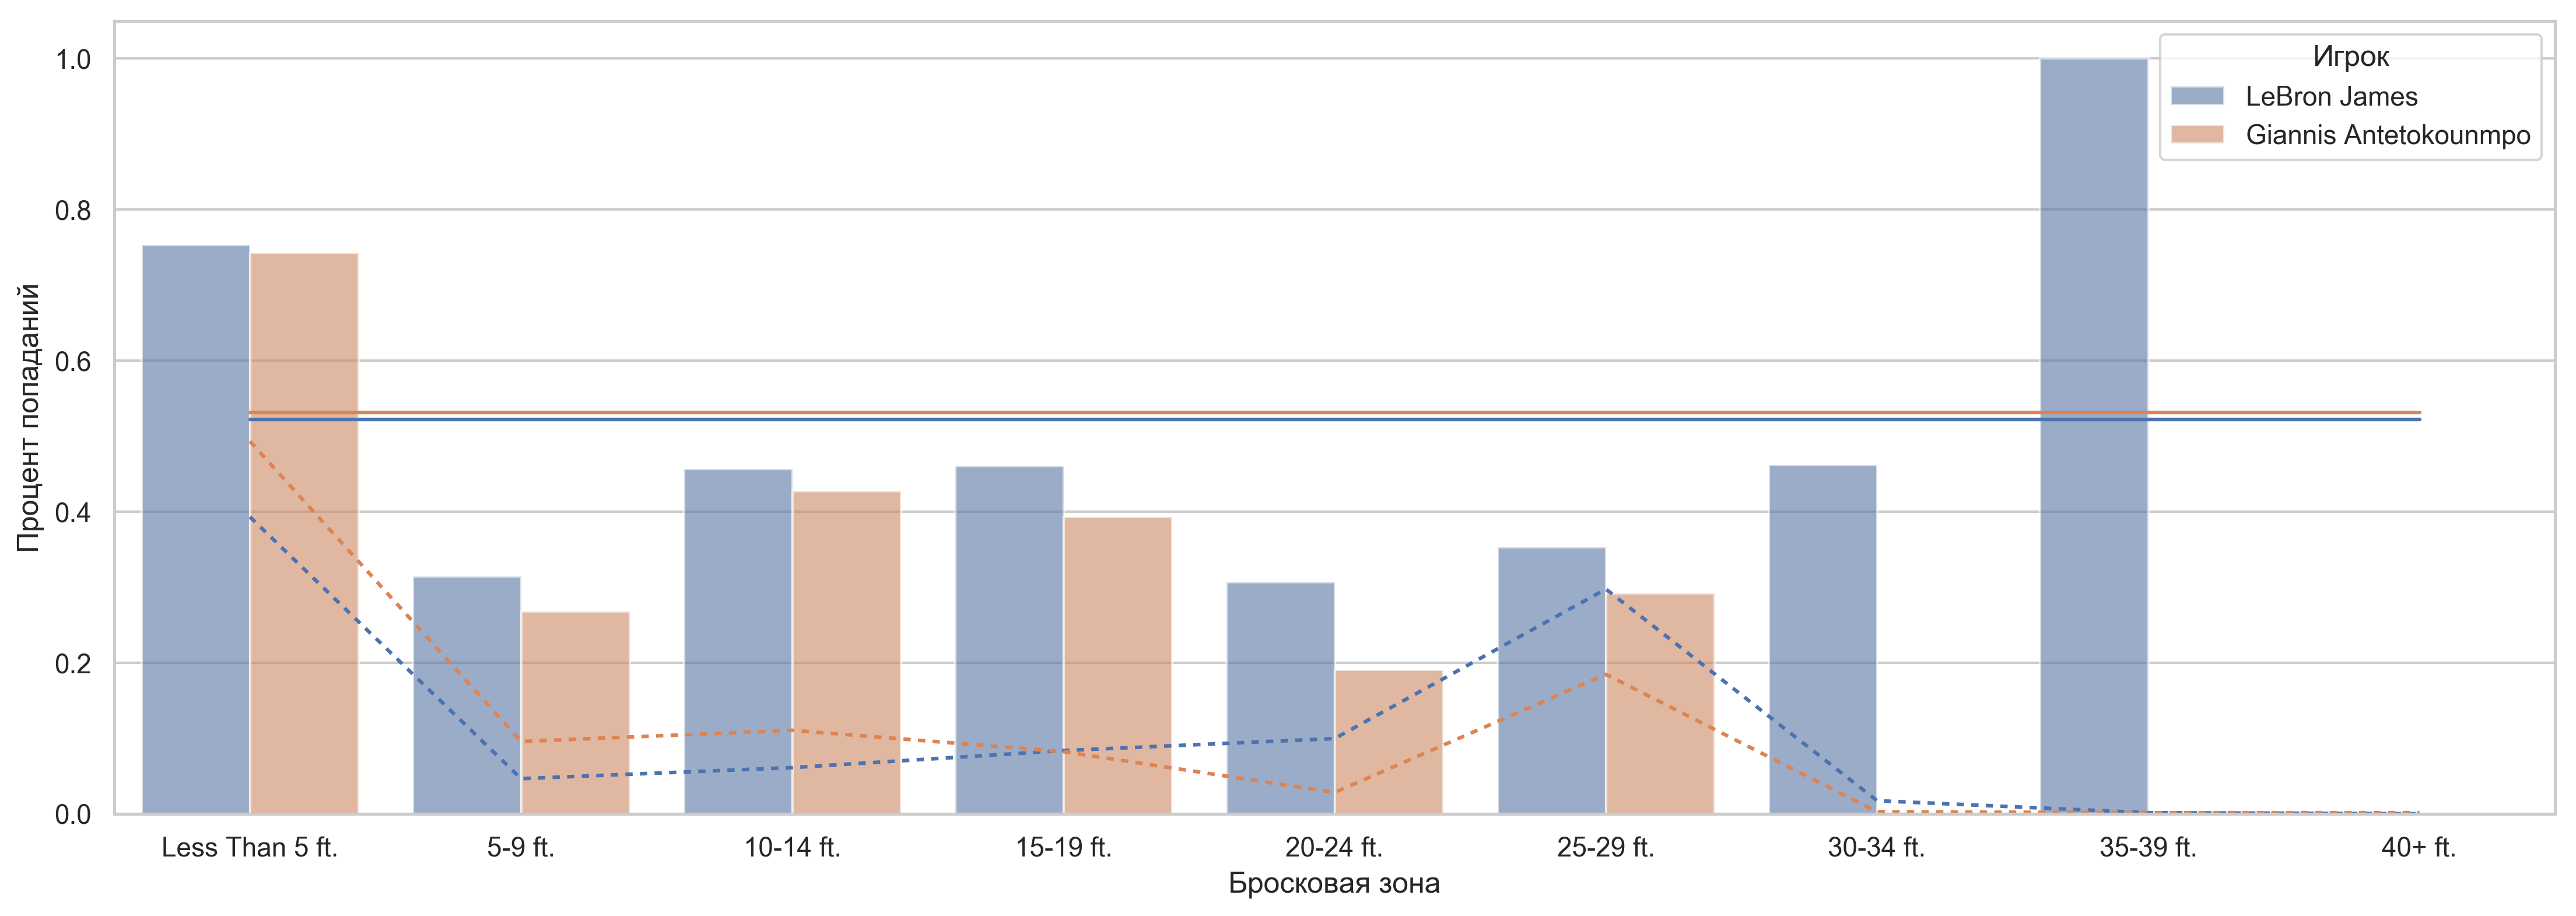

In [25]:
def plot_cmp(tt, save_fpath=None):
    f, ax = plt.subplots(figsize=(18, 6), dpi=300)# if save_fpath is None else 1000)
    sns.lineplot(data=tt, x='Бросковая зона', y='fga_share', hue='Игрок',  
                 style=True, dashes=[(2, 2), (2, 2)], legend=False, ax=ax)
    sns.lineplot(data=tt, x='Бросковая зона', y='total_pct', hue='Игрок', legend=False, ax=ax)
    
    sns.barplot(data=tt, x='Бросковая зона', y='Процент попаданий', hue='Игрок', alpha=0.6, ax=ax)
    if save_fpath is not None:
        f.savefig(save_fpath, dpi=200)

plot_cmp(tt, save_fpath='5ft_lebron_giannis.png')

In [31]:
tt = prepare_cmp(sp_8ft.loc[7], areas=AREAS_8FT)
tt

,level_0,Игрок,Процент попаданий,fga,Бросковая зона,fga_share,total_pct
0,Less Than 8 ft.,Donovan Mitchell,0.587413,286.0,Less Than 8 ft.,0.346667,0.450363
1,Less Than 8 ft.,Tobias Harris,0.573883,291.0,Less Than 8 ft.,0.494058,0.473684
2,8-16 ft.,Donovan Mitchell,0.486239,109.0,8-16 ft.,0.132121,0.450363
3,8-16 ft.,Tobias Harris,0.418605,129.0,8-16 ft.,0.219015,0.473684
4,16-24 ft.,Donovan Mitchell,0.433962,53.0,16-24 ft.,0.064242,0.450363
5,16-24 ft.,Tobias Harris,0.370370,27.0,16-24 ft.,0.045840,0.473684
6,24+ ft.,Donovan Mitchell,0.339523,377.0,24+ ft.,0.456970,0.450363
7,24+ ft.,Tobias Harris,0.338028,142.0,24+ ft.,0.241087,0.473684


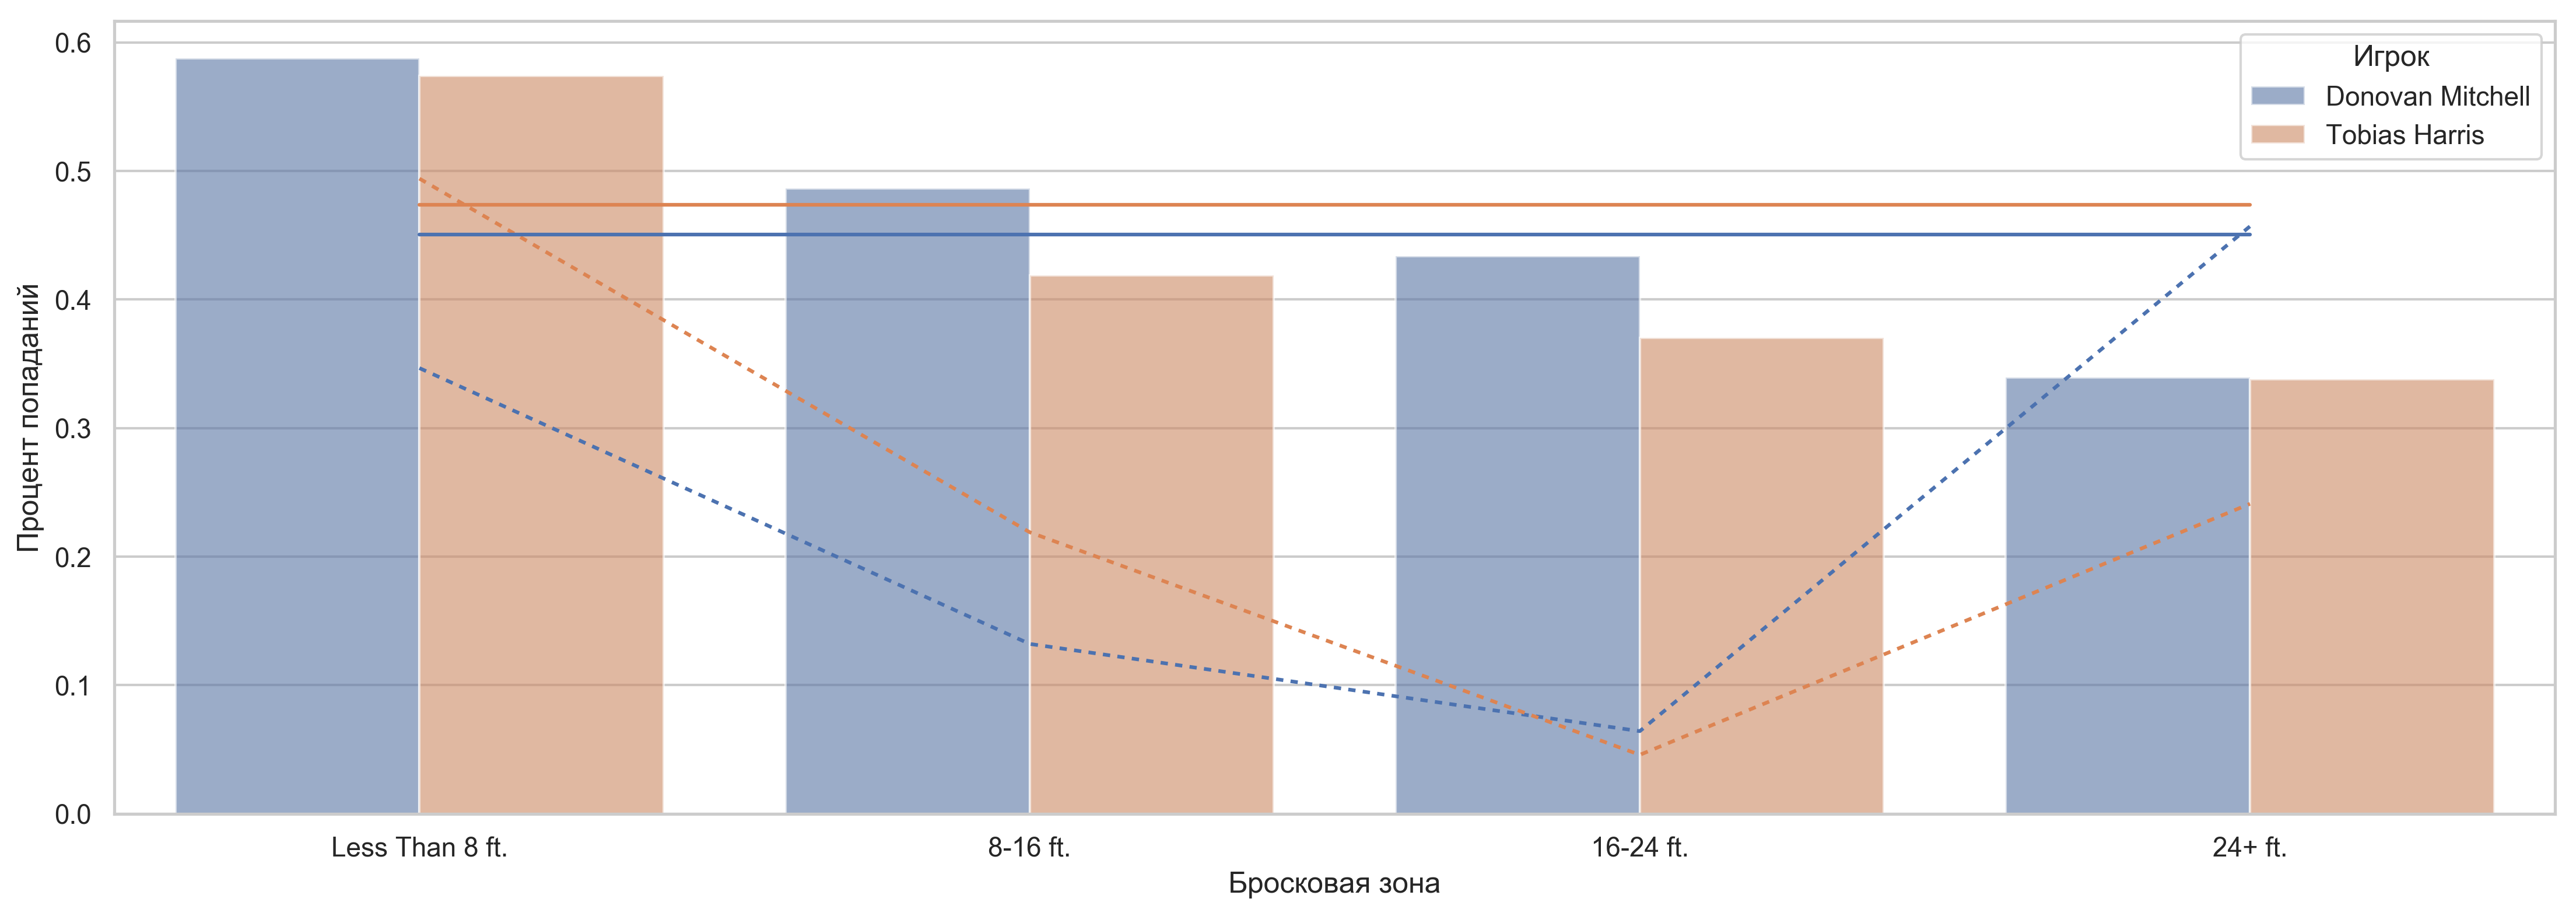

In [27]:
plot_cmp(tt, save_fpath='8ft_mitchell_harris.png')

In [28]:
sp_zones

Из-под кольца                  Из краски         \
                                      FGA    FGM         %       FGA    FGM   
num player_slug                                                               
1   Kevin Durant                     97.0   72.0  0.742268     198.0  100.0   
    Domantas Sabonis                316.0  230.0  0.727848      83.0   38.0   
2   Paul George                     102.0   61.0  0.598039      80.0   32.0   
    Russell Westbrook               346.0  197.0  0.569364     125.0   39.0   
3   Donovan Mitchell                181.0  118.0  0.651934     179.0   84.0   
    De'Aaron Fox                    188.0  120.0  0.638298     245.0  113.0   
4   D'Angelo Russell                 77.0   47.0  0.610390      94.0   39.0   
    Shai Gilgeous-Alexander         241.0  145.0  0.601660     221.0   88.0   
5   D'Angelo Russell                 77.0   47.0  0.610390      94.0   39.0   
    Jaren Jackson Jr.               182.0  107.0  0.587912     205.0   81.0   

                                      Со средней                  3 слева  \
                                    %        FGA    FGM         %     FGA   
num player_slug                                                             
1   Kevin Durant             0.505051      254.0  140.0  0.551181     4.0   
    Domantas Sabonis         0.457831       34.0    8.0  0.235294    11.0   
2   Paul George              0.400000      157.0   71.0  0.452229    18.0   
    Russell Westbrook        0.312000      149.0   61.0  0.409396    19.0   
3   Donovan Mitchell         0.469274       88.0   42.0  0.477273    22.0   
    De'Aaron Fox             0.461224      148.0   66.0  0.445946    14.0   
4   D'Angelo Russell         0.414894      110.0   47.0  0.427273    13.0   
    Shai Gilgeous-Alexander  0.398190       78.0   30.0  0.384615     9.0   
5   D'Angelo Russell         0.414894      110.0   47.0  0.427273    13.0   
    Jaren Jackson Jr.        0.395122       14.0    5.0  0.357143    25.0   

                                           3 справа                  \
                             FGM         %      FGA   FGM         %   
num player_slug                                                       
1   Kevin Durant             2.0  0.500000     10.0   6.0  0.600000   
    Domantas Sabonis         2.0  0.181818      5.0   2.0  0.400000   
2   Paul George              9.0  0.500000     21.0  11.0  0.523810   
    Russell Westbrook        8.0  0.421053     11.0   5.0  0.454545   
3   Donovan Mitchell         7.0  0.318182     20.0   6.0  0.300000   
    De'Aaron Fox             4.0  0.285714      7.0   0.0  0.000000   
4   D'Angelo Russell         8.0  0.615385     10.0   4.0  0.400000   
    Shai Gilgeous-Alexander  2.0  0.222222     10.0   4.0  0.400000   
5   D'Angelo Russell         8.0  0.615385     10.0   4.0  0.400000   
    Jaren Jackson Jr.        6.0  0.240000     27.0  10.0  0.370370   

                            3 по центру                  Со своей половины  \
                                    FGA    FGM         %               FGA   
num player_slug                                                              
1   Kevin Durant                  166.0   59.0  0.355422               0.0   
    Domantas Sabonis               88.0   30.0  0.340909               0.0   
2   Paul George                   178.0   50.0  0.280899               0.0   
    Russell Westbrook             137.0   37.0  0.270073               0.0   
3   Donovan Mitchell              335.0  115.0  0.343284               1.0   
    De'Aaron Fox                  136.0   35.0  0.257353               0.0   
4   D'Angelo Russell              297.0  102.0  0.343434               2.0   
    Shai Gilgeous-Alexander       219.0   61.0  0.278539               0.0   
5   D'Angelo Russell              297.0  102.0  0.343434               2.0   
    Jaren Jackson Jr.             215.0   68.0  0.316279               0.0   

                                       Total               

In [29]:
tt = prepare_cmp(sp_zones.loc[1], areas=AREAS_ZONES)
tt

,level_0,Игрок,Процент попаданий,fga,Бросковая зона,fga_share,total_pct
0,Из-под кольца,Kevin Durant,0.742268,97.0,Из-под кольца,0.133059,0.519890
1,Из-под кольца,Domantas Sabonis,0.727848,316.0,Из-под кольца,0.588454,0.577281
2,Из краски,Kevin Durant,0.505051,198.0,Из краски,0.271605,0.519890
3,Из краски,Domantas Sabonis,0.457831,83.0,Из краски,0.154562,0.577281
4,Со средней,Kevin Durant,0.551181,254.0,Со средней,0.348422,0.519890
5,Со средней,Domantas Sabonis,0.235294,34.0,Со средней,0.063315,0.577281
6,3 слева,Kevin Durant,0.500000,4.0,3 слева,0.005487,0.519890
7,3 слева,Domantas Sabonis,0.181818,11.0,3 слева,0.020484,0.577281
8,3 справа,Kevin Durant,0.600000,10.0,3 справа,0.013717,0.519890
9,3 справа,Domantas Sabonis,0.400000,5.0,3 справа,0.009311,0.577281


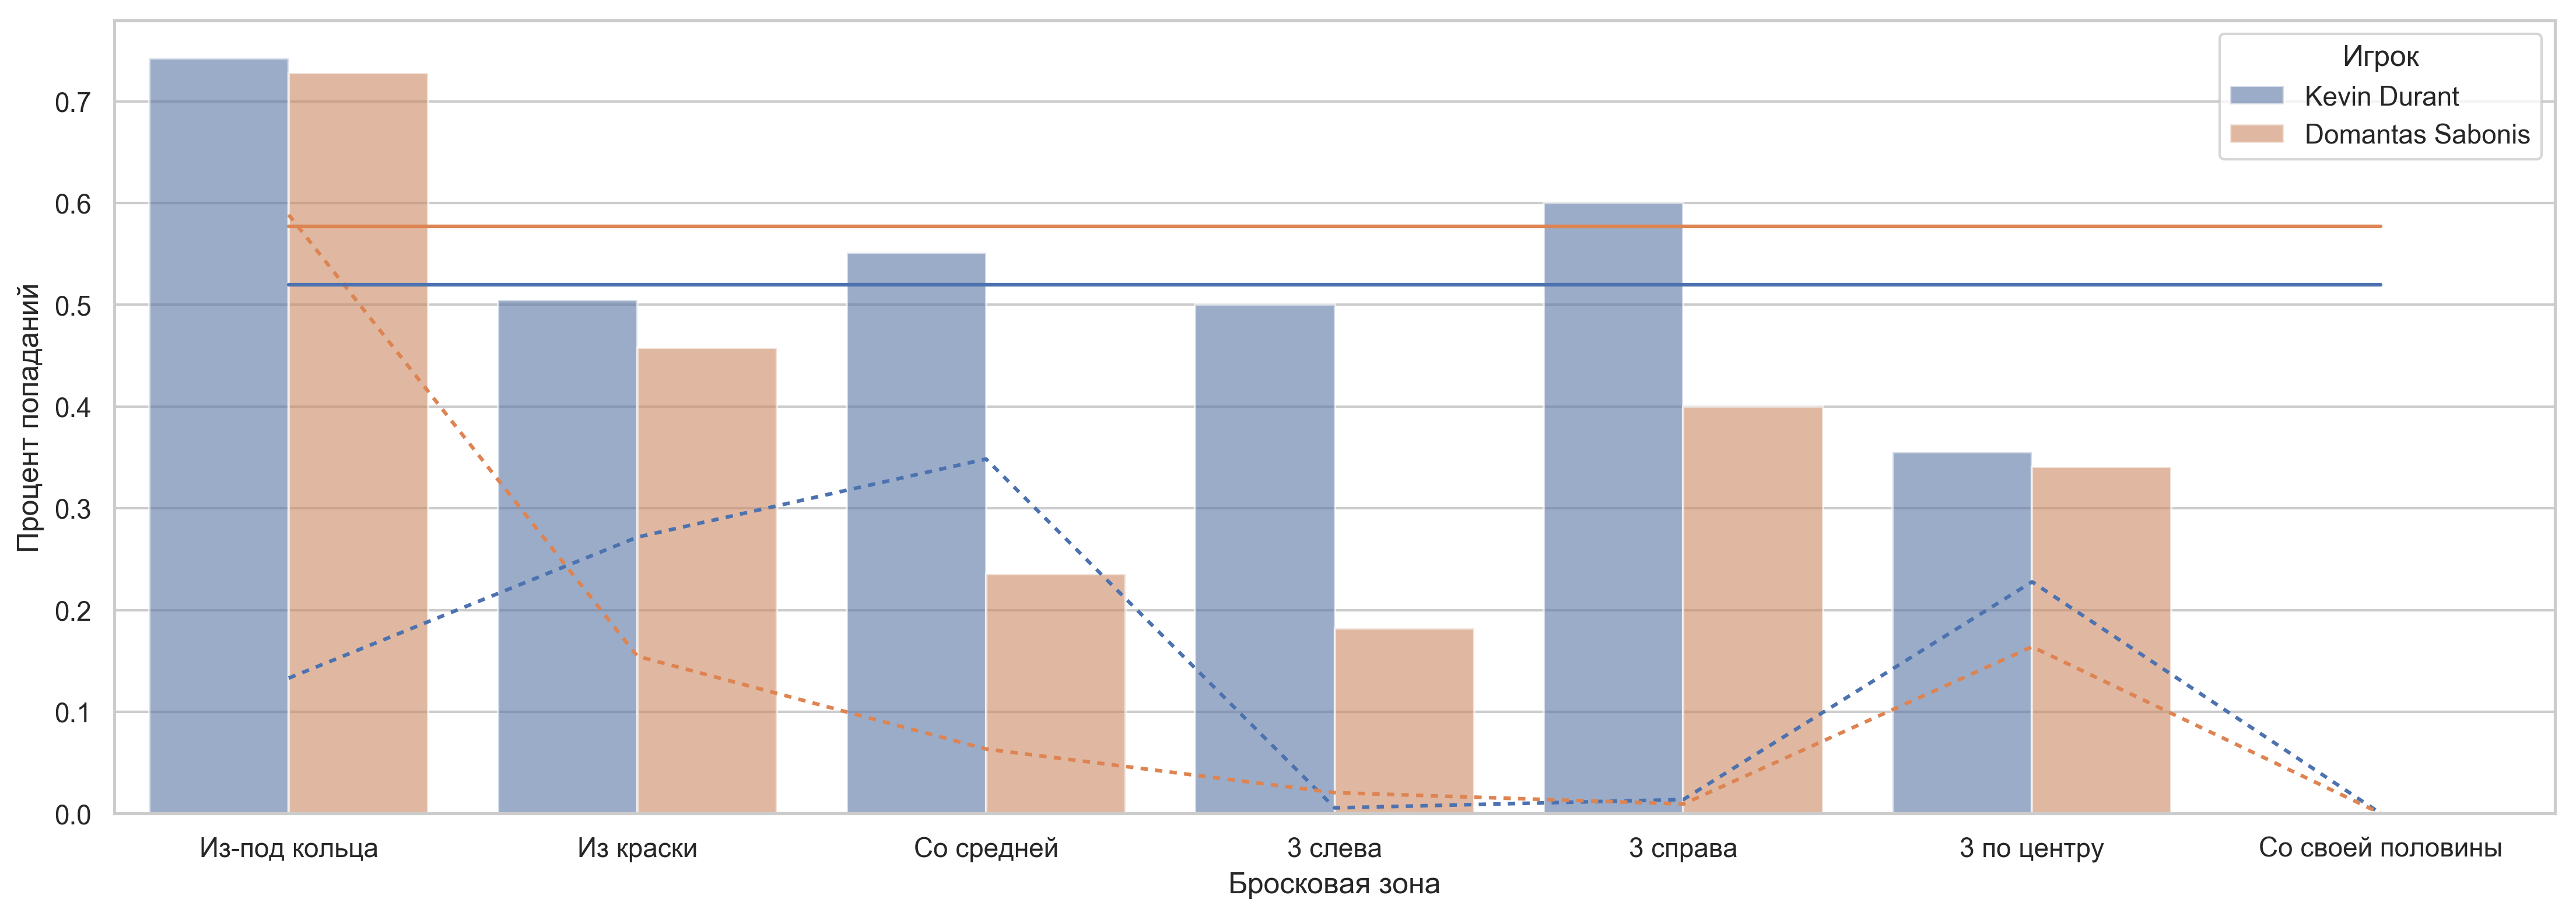

In [30]:
plot_cmp(tt, save_fpath='zones_sabas_durant.png')